# Лабораторная работа №5. Применение сверточных нейронных сетей (бинарная классификация)

Данные: Набор данных DogsVsCats, который состоит из изображений различной размерности, содержащих фотографии собак и кошек. Обучающая выборка включает в себя 25 тыс. изображений (12,5 тыс. кошек: cat.0.jpg, …, cat.12499.jpg и 12,5 тыс. собак: dog.0.jpg, …, dog.12499.jpg), а контрольная выборка содержит 12,5 тыс. неразмеченных изображений. Скачать данные, а также проверить качество классификатора на тестовой выборке можно на сайте Kaggle -> https://www.kaggle.com/c/dogs-vs-cats/data

In [0]:
import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pathlib
import zipfile
import os

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

Если файлы недоступны перезалейте их на сайте anonfile.

(или перейдите по ссылкам ниже и скопируйте ссылку приаттаченную на кнопке download)

In [0]:
# https://cdn-35.anonfile.com/LbX1j7m8o2/e71cffa9-1586089795/train.zip
train_file_path = tf.keras.utils.get_file(origin='https://filebin.net/59yrr2otsk1mvs3o/train.zip?t=vmxbo5qt',
                                          fname='train.zip', cache_dir='/content')

train_data_dir = pathlib.Path('./datasets/train/')

with zipfile.ZipFile(train_file_path, 'r') as zip_ref:
    zip_ref.extractall('./datasets/')

IMAGE_COUNT = len(list(train_data_dir.glob('*')))
IMAGE_COUNT

569548800/569546721 [==============================] - 30s 0us/step


25000

Мы должны привести все картинки к одному размеру.
Для этого необходимо найти наибольшие размеры картинок.

In [0]:
MAX_HEIGHT, MAX_WIDTH = (256, 256)
MAX_HEIGHT, MAX_WIDTH

(256, 256)

In [0]:
PATHS = [str(item) for item in train_data_dir.glob('*')]

cats_count = len(list(train_data_dir.glob('cat*')))
LABLES = np.concatenate([['cat'] * cats_count, ['dog'] * (IMAGE_COUNT - cats_count)])#
# LABLES = np.concatenate([np.zeros(cats_count), np.ones(IMAGE_COUNT - cats_count)])

In [0]:
import random
import datetime
from keras_preprocessing.image import DataFrameIterator

class Model:
    EPOCH_COUNT = 10
    
    def __init__(self, layers=[], model=None, optimizer=None):
        self.layers = layers
        self.model = model
        self.optimizer = optimizer or tf.keras.optimizers.SGD(
            learning_rate=0.1
        )
        if not self.model:
            self.initialize()
        print('----------------------------------------------------------------------------------------')
        print(self.summary())
        print('----------------------------------------------------------------------------------------')

    def initialize(self):
        self.model = tf.keras.models.Sequential(self.layers)
        self.model.compile(optimizer=self.optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        
    def _train_on_batches(self, iterator, batch_count, epochs=None, **kwargs):
        epochs = epochs or self.EPOCH_COUNT
        loss, tran_accuracy, val_accuracy = np.zeros((3, batch_count, epochs))

        for i in range(batch_count):
            print('----------------------------------------------------------------------------------------')
            print(f'Train on batch #{i}')
            print('----------------------------------------------------------------------------------------')
            x, y = next(iterator)
            batch_history = self.model.fit(x,  y, epochs=epochs, **kwargs)
            loss[i, :] = batch_history.history['loss']
            tran_accuracy[i, :] = batch_history.history['accuracy']
            if batch_history.history.get('val_accuracy'):
                val_accuracy[i, :] = batch_history.history.get('val_accuracy')[-1]

        val_accuracy = val_accuracy if np.any(val_accuracy) else None

        return loss, tran_accuracy, val_accuracy

    def _train_on_full_data(self, iterator, epochs=None, **kwargs):
        print('----------------------------------------------------------------------------------------')
        print(f'Train on full data')
        print('----------------------------------------------------------------------------------------')
        epochs = epochs or self.EPOCH_COUNT
        history = self.model.fit(iterator, epochs=epochs, **kwargs)
        loss = np.array([history.history['loss']])
        tran_accuracy = np.array([history.history['accuracy']])
        val_accuracy = np.array([history.history.get('val_accuracy')])

        val_accuracy = val_accuracy if np.any(val_accuracy) else None

        return loss, tran_accuracy, val_accuracy

    def _plot_train_accuracy_graphs(self, loss, tran_accuracy, mode='batch'):
        print('----------------------------------------------------------------------------------------')
        if mode == 'batch':
            plt.figure(figsize=(15, 12))
            ax_shape = (2, 2)
        else:
            plt.figure(figsize=(15,5))
            ax_shape = (1, 2)

        epochs_loss = np.average(loss, axis=0)
        xlabel = 'Epochs'
        ax = plt.subplot(*ax_shape, 1)
        ax.plot(epochs_loss)
        ax.set_xlabel(xlabel, fontsize=14)
        ax.set_ylabel('Loss', fontsize=14)

        epochs_accuracy = np.average(tran_accuracy, axis=0)
        ax = plt.subplot(*ax_shape, 2)
        ax.plot(epochs_accuracy)
        ax.set_xlabel(xlabel, fontsize=14)
        ax.set_ylabel('Accuracy', fontsize=14)

        if mode == 'batch':
            batches_loss = np.average(loss, axis=1)
            xlabel = 'Batches'
            ax = plt.subplot(*ax_shape, 3)
            ax.plot(batches_loss)
            ax.set_xlabel(xlabel, fontsize=14)
            ax.set_ylabel('Loss', fontsize=14)

            batches_accuracy = np.average(tran_accuracy, axis=1)
            ax = plt.subplot(*ax_shape, 4)
            ax.plot(batches_accuracy)
            ax.set_xlabel(xlabel, fontsize=14)
            ax.set_ylabel('Accuracy', fontsize=14)
        
        plt.show()

    def _show_train_result(self, spent_time, average_loss, average_tran_accuracy, val_accuracy=None):
        print('----------------------------------------------------------------------------------------')
        print('Spent time:', spent_time)
        print('Average loss error:', average_loss)
        print('Average train error:', average_tran_accuracy)
        if val_accuracy is not None:
            print('Average validation error:', val_accuracy)
        print('----------------------------------------------------------------------------------------')

    def train(self, iterator, batch_count=None, show_accuracy_graph=True, **kwargs):
        now = datetime.datetime.now()
        val_accuracy = None

        if batch_count:
            loss, tran_accuracy, val_accuracy =  self._train_on_batches(iterator, batch_count, **kwargs)
        else:
            print('----------------------------------------------------------------------------------------')
            print(f'Started at {now}')
            loss, tran_accuracy, val_accuracy =  self._train_on_full_data(iterator, **kwargs)

        if show_accuracy_graph:
            mode = 'batch' if batch_count else 'epoch'
            self._plot_train_accuracy_graphs(loss, tran_accuracy, mode=mode)


        average_loss = np.average(loss)
        average_tran_accuracy = np.average(tran_accuracy)
        average_val_accuracy = val_accuracy and np.average(val_accuracy)
        self._show_train_result(
            datetime.datetime.now() - now,
            average_loss,
            average_tran_accuracy,
            average_val_accuracy
        )

        return {'loss': loss, 'accuracy': tran_accuracy, 'val_accuracy': val_accuracy}

    def test(self, x_test, y_test=None, **kwargs):
        return self.model.evaluate(x_test,  y_test, **kwargs)
    
    def summary(self):
        return self.model.summary()

    def predict(self, data, **kwargs):
        return self.model.predict(data, **kwargs)

    def save(self, **kwargs):
        filedir = kwargs.pop('filedir', './')
        filepath = filedir + kwargs.pop('filename', self.model.name)
        tf.keras.models.save_model(self.model, filepath, **kwargs)

### Задание 1. Загрузите данные. Разделите исходный набор данных на обучающую, валидационную и контрольную выборки.


In [0]:
x_train, x_left, y_train, y_left = train_test_split(sorted(PATHS), LABLES, test_size=0.4, shuffle=True)
x_validation, x_test, y_validation, y_test = train_test_split(x_left, y_left, test_size=0.5, shuffle=True)

In [0]:
BATCH_SIZE = 64

In [0]:
def create_generator(x, y, target_size=(MAX_HEIGHT, MAX_WIDTH), batch_size=BATCH_SIZE):
    dataframe = pd.DataFrame({'filename': x, 'class': y })
    image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    data_generator = image_generator.flow_from_dataframe(
        dataframe, target_size=target_size, class_mode='binary', batch_size=batch_size, shuffle=True
    )
    return data_generator

In [0]:
train_generator = create_generator(x_train, y_train)

Found 15000 validated image filenames belonging to 2 classes.


In [0]:
validation_generator = create_generator(x_validation, y_validation)

Found 5000 validated image filenames belonging to 2 classes.


In [0]:
test_generator = create_generator(x_test, y_test)

Found 5000 validated image filenames belonging to 2 classes.


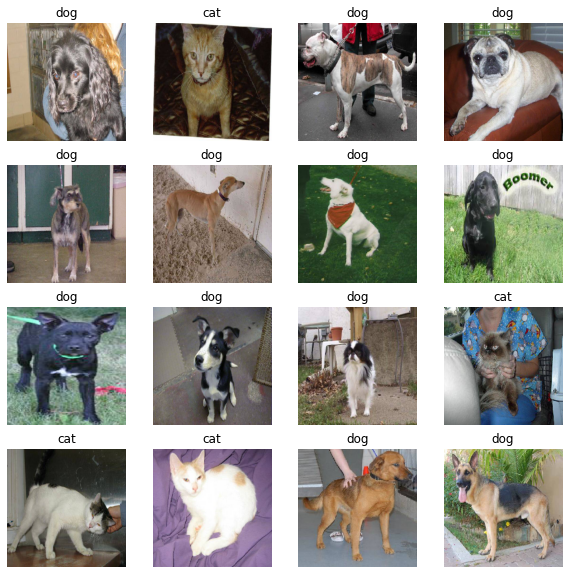

In [0]:
def show_samples_from_iterator(iterator):
    image_batch, label_batch = next(iterator)
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n, :, :, :])
        plt.title('dog' if label_batch[n] else 'cat')
        plt.axis('off')

show_samples_from_iterator(iter(train_generator))

### Задание 2. Реализуйте глубокую нейронную сеть с как минимум тремя сверточными слоями. Какое качество классификации получено?


In [0]:
layers = [
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(MAX_HEIGHT, MAX_WIDTH, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
]

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model = Model(layers=layers, optimizer=optimizer)

----------------------------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________

Streaming output truncated to the last 5000 lines.
Epoch 16/20
2/2 [==============================] - 0s 22ms/step - loss: 0.0225 - accuracy: 1.0000
Epoch 17/20
2/2 [==============================] - 0s 22ms/step - loss: 0.0201 - accuracy: 1.0000
Epoch 18/20
2/2 [==============================] - 0s 22ms/step - loss: 0.0178 - accuracy: 1.0000
Epoch 19/20
2/2 [==============================] - 0s 21ms/step - loss: 0.0161 - accuracy: 1.0000
Epoch 20/20
2/2 [==============================] - 0s 21ms/step - loss: 0.0145 - accuracy: 1.0000
----------------------------------------------------------------------------------------
Train on batch #119
----------------------------------------------------------------------------------------
Epoch 1/20
2/2 [==============================] - 0s 22ms/step - loss: 1.0840 - accuracy: 0.6094
Epoch 2/20
2/2 [==============================] - 0s 21ms/step - loss: 0.8673 - accuracy: 0.6719
Epoch 3/20
2/2 [==============================] - 0s 23ms/step - lo

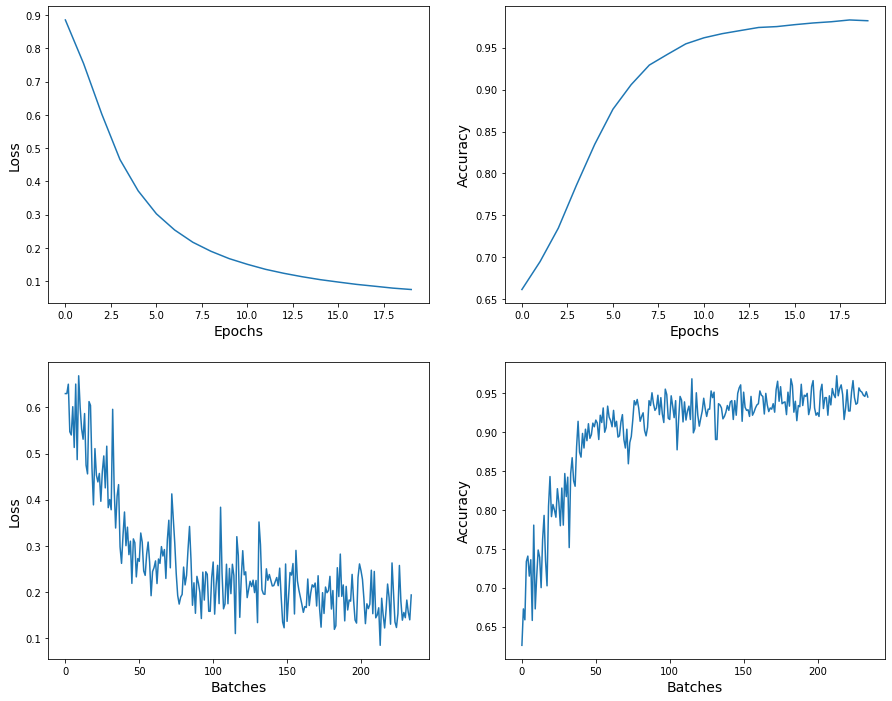

----------------------------------------------------------------------------------------
Spent time: 0:08:04.091927
Average loss error: 0.26338052535518763
Average train error: 0.9035826684312618
----------------------------------------------------------------------------------------
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/5/model/assets


In [0]:
with tf.device('/device:GPU:0'):
    history = model.train(iter(train_generator), batch_count=len(train_generator), epochs=20, workers=4)
    model.save(filedir='/content/drive/My Drive/Colab Notebooks/5/', filename='model')

In [0]:
with tf.device('/device:GPU:0'):
    history = model.test(iter(validation_generator), steps=len(validation_generator))

79/79 [==============================] - 18s 223ms/step - loss: 0.8205 - accuracy: 0.7026


In [0]:
with tf.device('/device:GPU:0'):
    history = model.test(iter(test_generator), steps=len(test_generator))

79/79 [==============================] - 17s 219ms/step - loss: 0.7941 - accuracy: 0.7124


### Задание 3. Примените дополнение данных (data augmentation). Как это повлияло на качество классификатора? 


In [0]:
def create_augmentation_generator(x, y, target_size=(MAX_HEIGHT, MAX_WIDTH)):
    dataframe = pd.DataFrame({'filename': x, 'class': y })

    image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=90.,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
		shear_range=0.15,
		horizontal_flip=True,
        brightness_range=(0.2,0.8),
		fill_mode="nearest"
    )

    data_generator = image_generator.flow_from_dataframe(
        dataframe, target_size=target_size, class_mode='binary', batch_size=BATCH_SIZE, shuffle=True
    )
    return data_generator

In [0]:
train_augmentation_generator = create_augmentation_generator(x_train, y_train)

Found 15000 validated image filenames belonging to 2 classes.


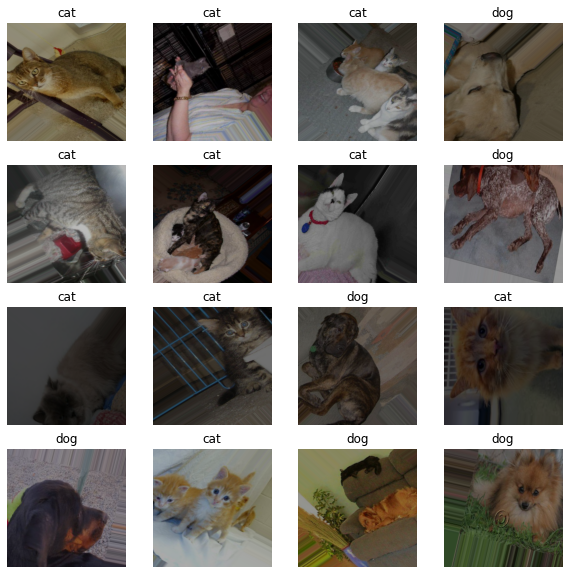

In [0]:
show_samples_from_iterator(iter(train_augmentation_generator))

Streaming output truncated to the last 5000 lines.
Epoch 16/20
2/2 [==============================] - 0s 23ms/step - loss: 0.0445 - accuracy: 1.0000
Epoch 17/20
2/2 [==============================] - 0s 21ms/step - loss: 0.0395 - accuracy: 1.0000
Epoch 18/20
2/2 [==============================] - 0s 22ms/step - loss: 0.0350 - accuracy: 1.0000
Epoch 19/20
2/2 [==============================] - 0s 20ms/step - loss: 0.0317 - accuracy: 1.0000
Epoch 20/20
2/2 [==============================] - 0s 21ms/step - loss: 0.0289 - accuracy: 1.0000
----------------------------------------------------------------------------------------
Train on batch #119
----------------------------------------------------------------------------------------
Epoch 1/20
2/2 [==============================] - 0s 22ms/step - loss: 0.9538 - accuracy: 0.6719
Epoch 2/20
2/2 [==============================] - 0s 22ms/step - loss: 0.6829 - accuracy: 0.6875
Epoch 3/20
2/2 [==============================] - 0s 23ms/step - lo

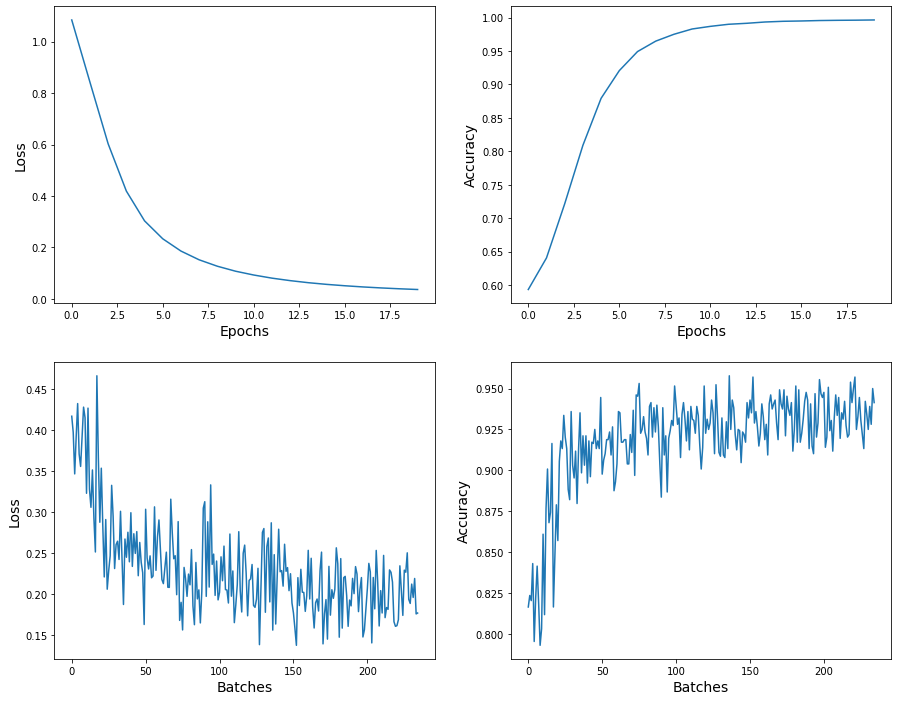

----------------------------------------------------------------------------------------
Spent time: 0:11:51.232334
Average loss error: 0.23204668740365417
Average train error: 0.9185305850937011
----------------------------------------------------------------------------------------
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/5/aug_model/assets


In [0]:
with tf.device('/device:GPU:0'):
    history = model.train(iter(train_augmentation_generator), batch_count=len(train_augmentation_generator), epochs=20, workers=4)
    model.save(filedir='/content/drive/My Drive/Colab Notebooks/5/', filename='aug_model')

In [0]:
with tf.device('/device:GPU:0'):
    history = model.test(iter(validation_generator), steps=len(validation_generator))

79/79 [==============================] - 18s 231ms/step - loss: 1.9395 - accuracy: 0.6048


In [0]:
with tf.device('/device:GPU:0'):
    history = model.test(iter(test_generator), steps=len(test_generator))

79/79 [==============================] - 18s 222ms/step - loss: 1.9881 - accuracy: 0.5934


### Задание 4. Поэкспериментируйте с готовыми нейронными сетями (например, AlexNet, VGG16, Inception и т.п.), применив передаточное обучение. Как это повлияло на качество классификатора? Какой максимальный результат удалось получить на сайте Kaggle? Почему?


#### VGG16

In [0]:
def VGG16():
    # load pretrained vgg16
    pretrain_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(MAX_HEIGHT, MAX_WIDTH, 3))
    # Make vgg16 model layers as non trainable
    for layer in pretrain_model.layers:
        layer.trainable = False

    # create custom output layer
    flatten_tensor = tf.keras.layers.Flatten()(pretrain_model.output)
    output_tensor = tf.keras.layers.Dense(1, activation='sigmoid')(flatten_tensor)

    # gather layers and create model
    pretrain_model = tf.keras.Model(inputs=pretrain_model.input, outputs=output_tensor)
    pretrain_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='binary_crossentropy', metrics=['accuracy'])
    return pretrain_model

In [0]:
vgg16_model = Model(model=VGG16())

58892288/58889256 [==============================] - 0s 0us/step
----------------------------------------------------------------------------------------
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 50ms/step - loss: 4.7277e-08 - accuracy: 1.0000
Epoch 8/10
2/2 [==============================] - 0s 51ms/step - loss: 0.4965 - accuracy: 0.9688
Epoch 9/10
2/2 [==============================] - 0s 48ms/step - loss: 1.6943e-06 - accuracy: 1.0000
Epoch 10/10
2/2 [==============================] - 0s 48ms/step - loss: 9.8760e-07 - accuracy: 1.0000
----------------------------------------------------------------------------------------
Train on batch #18
----------------------------------------------------------------------------------------
Epoch 1/10
2/2 [==============================] - 0s 50ms/step - loss: 11.9322 - accuracy: 0.8750
Epoch 2/10
2/2 [==============================] - 0s 50ms/step - loss: 5.5370 - accuracy: 0.9219
Epoch 3/10
2/2 [==============================] - 0s 49ms/step - loss: 2.2678 - accuracy: 0.9375
Epoch 4/10
2/2 [==============================] - 0s 49ms/step - loss:

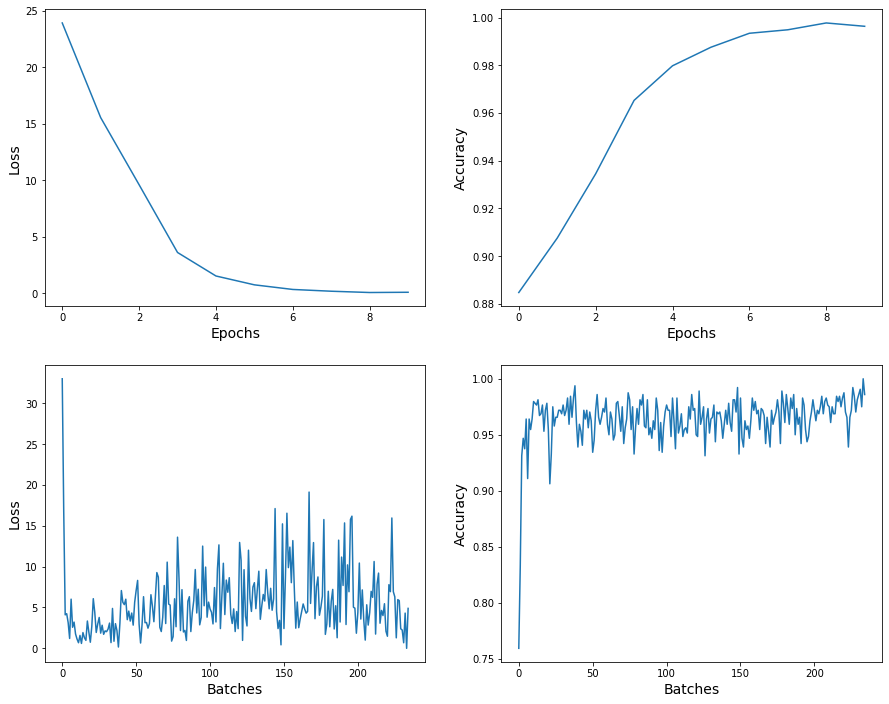

----------------------------------------------------------------------------------------
Spent time: 0:08:47.788037
Average loss error: 5.56949839595437
Average train error: 0.9641888297872341
----------------------------------------------------------------------------------------
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/5/vgg16_based_model/assets


In [0]:
with tf.device('/device:GPU:0'):
    history = vgg16_model.train(iter(train_generator), batch_count=len(train_generator), epochs=10, workers=4)
    model.save(filedir='/content/drive/My Drive/Colab Notebooks/5/', filename='vgg16_based_model')

In [0]:
with tf.device('/device:GPU:0'):
    history = vgg16_model.test(iter(validation_generator), steps=len(validation_generator))

79/79 [==============================] - 19s 241ms/step - loss: 30.5305 - accuracy: 0.9042


In [0]:
with tf.device('/device:GPU:0'):
    history = vgg16_model.test(iter(test_generator), steps=len(test_generator))

79/79 [==============================] - 19s 245ms/step - loss: 30.2098 - accuracy: 0.9060


#### Создание предсказаний Kaggle

In [0]:
# https://cdn-35.anonfile.com/LbX1j7m8o2/e71cffa9-1586089795/train.zip
test1_file_path = tf.keras.utils.get_file(origin='https://filebin.net/59yrr2otsk1mvs3o/test1.zip?t=o3vejop6',
                                          fname='test1.zip', cache_dir='/content')

test1_data_dir = pathlib.Path('./datasets/test/')

with zipfile.ZipFile(test1_file_path, 'r') as zip_ref:
    zip_ref.extractall('./datasets/test/')

len(list(test1_data_dir.glob('*')))

284327936/284321224 [==============================] - 15s 0us/step


1

In [0]:
def create_image_generator(data_dir, target_size=(MAX_HEIGHT, MAX_WIDTH), batch_size=BATCH_SIZE):
    image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    data_generator = image_generator.flow_from_directory(
        directory=str(data_dir), target_size=target_size, class_mode=None, batch_size=batch_size
    )
    return data_generator

In [0]:
test1_data_generator = create_image_generator(test1_data_dir)

Found 12500 images belonging to 1 classes.


In [0]:
def predict_by_model(model, generator, filename):
    results = model.predict(generator, verbose=1, workers=4, steps=len(generator))
    int_results = np.rint(results).astype(int)
    df = pd.DataFrame(data={'id': list(range(1, int_results.shape[0] + 1)), 'label': int_results[:, 0]})
    df.to_csv(f'{filename}.csv', index=False)  

In [0]:
predict_by_model(model, test1_data_generator, '/content/drive/My Drive/Colab Notebooks/5/model_submission')

196/196 [==============================] - 22s 111ms/step


In [0]:
predict_by_model(vgg16_model, test1_data_generator, '/content/drive/My Drive/Colab Notebooks/5/vgg16_model_submission')

196/196 [==============================] - 41s 208ms/step
